In [1]:
### Import Packages

# File manipulation

import os # For working with Operating System
import requests # Accessing the Web
import datetime as dt # Working with dates/times
import io # Input/Output Bytes objects
import time # For sleep in for loop

# Analysis

import numpy as np
import pandas as pd
import geopandas as gpd

# Visualization

import contextily as ctx # Basemaps
import matplotlib.pyplot as plt # Basic Plotting
import seaborn as sns # Statistical Plotting


# Definitions

In [2]:
# This is my personal API key... Please use responsibly!

api = input('Please enter your Purple Air api key')

Please enter your Purple Air api key 51592903-B445-11ED-B6F4-42010A800007


In [3]:
# Get Sensor Locations

def getSensorsData(query='', api_read_key=''):

    # my_url is assigned the URL we are going to send our request to.
    url = 'https://api.purpleair.com/v1/sensors?' + query
    
    # print('Here is the full url for the API call:\n\n', url)

    # my_headers is assigned the context of our request we want to make. In this case
    # we will pass through our API read key using the variable created above.
    my_headers = {'X-API-Key':api_read_key}

    # This line creates and sends the request and then assigns its response to the
    # variable, r.
    response = requests.get(url, headers=my_headers)

    # We then return the response we received.
    return response

# Data

In [4]:
## Load Data

data_path = os.path.join('..', '..', 'data')

spikes = pd.read_csv(os.path.join(data_path, 'all_spikes_06152022-04202023.csv'))

spikes['timestamp'] = pd.to_datetime(spikes.timestamp)

summaries = pd.read_csv(os.path.join(data_path, 'daily_summaries_06152022-04202023.csv'))
summaries['date'] = pd.to_datetime(summaries.date)

summaries_no_spikes = pd.read_csv(os.path.join(data_path, 'daily_summaries_06152022-04202023.csv'))
summaries_no_spikes['date'] = pd.to_datetime(summaries_no_spikes.date)

# Sensor Indices (from City of Minneapolis)

indices_path = os.path.join(data_path, 'PA IDs and indexes.xlsx')

sensor_info = pd.read_excel(indices_path) # Load as DataFrame

sensor_ids = sensor_info['Sensor Index'].dropna().astype(int)

In [5]:
# Locations

sensor_string = 'show_only=' + '%2C'.join(sensor_ids.astype(str))

query = 'fields=latitude%2Clongitude&' + sensor_string

response = getSensorsData(query, api)

response_dict = response.json() # Read response as a json (dictionary)

col_names = response_dict['fields']
data = np.array(response_dict['data'])

sensors_df = pd.DataFrame(data, columns = col_names)

In [6]:
# Spatialize

sensors = gpd.GeoDataFrame(sensors_df.sensor_index,
                 geometry = gpd.points_from_xy(x=sensors_df.longitude, y=sensors_df.latitude),
                           crs = 'EPSG:4326'
                ).to_crs('EPSG:26915')

# Explore 

## Number of Sensors By Date

In [7]:
# Select only days with more than 100 observations

select = summaries[summaries.n_observations > 100]

In [8]:
# Find number of stations by date

n_stations = select.groupby('date').count()['sensor_index']

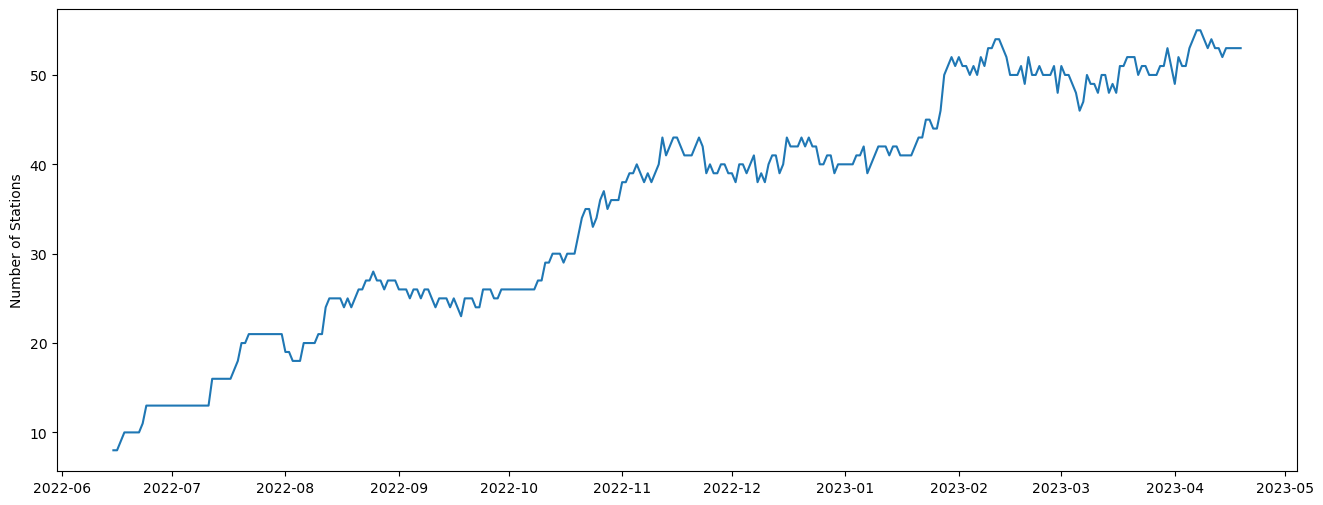

In [9]:
f, ax = plt.subplots(1, figsize = (16,6))

dates = n_stations.index.values

sns.lineplot(x = n_stations.index.values,
             y = n_stations.values,
             ax = ax)

ax.set_ylabel('Number of Stations')

plt.show()

In [10]:
# Let's set 30 sensors as the cutoff date

n_stations[n_stations>30].head()

date
2022-10-20    32
2022-10-21    34
2022-10-22    35
2022-10-23    35
2022-10-24    33
Name: sensor_index, dtype: int64

In [11]:
# Date

first_day = n_stations[n_stations>30].index[0]

## Number of Days Observed

In [12]:
select_dates = select[select.date > first_day]

In [13]:
# Find the sensors that have enough days

obs_by_station = select_dates.groupby('sensor_index').count().n_observations

In [14]:
obs_by_station.min()

2

82.0


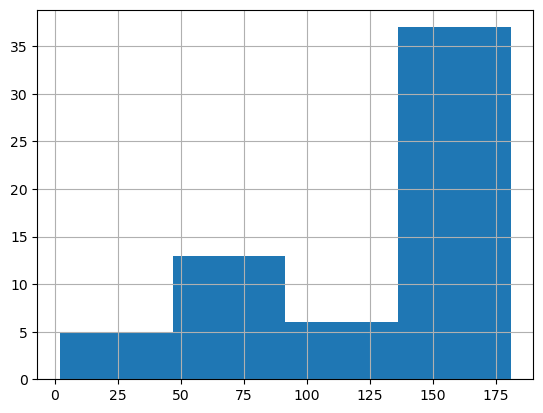

In [15]:
# Well we don't want that one!

n_bins = 4

obs_by_station.hist(bins = n_bins)

print(obs_by_station.quantile(1/n_bins))

In [18]:
# It's been how long?

time_since = dt.datetime.today() - first_day

print(time_since)

184 days 11:19:10.468321


In [28]:
# 184 Days so we should have at least... 90%?

In [29]:
# Select those stations

min_n_days = (time_since*.9).days

stations_ids_w_enough_days = obs_by_station[obs_by_station > min_n_days].index.values

# Filter from select dates

is_enough_days = select_dates.sensor_index.isin(stations_ids_w_enough_days)

stations_w_enough_days = select_dates[is_enough_days]

In [30]:
# Is it a business day?

# Removing the weekends

dayofweek = stations_w_enough_days.date.apply(lambda x: x.dayofweek) # Monday = 0

stations_for_avg = stations_w_enough_days[dayofweek < 5]

In [31]:
# For finding if a string of dates is consecutive

# def is_consecutive(datelist):
#     '''this function takes a list of np.datetimes
#     and tells if they are consecutive'''
    
#     date_ints = set([pd.Timestamp(d).toordinal() for d in datelist])

#     if len(date_ints) == 1:
#         return False
#     elif max(date_ints) - min(date_ints) == len(date_ints) - 1:
#         return True
#     else:
#         return False

    

# dates_by_station = stations_w_enough_days.groupby('sensor_index').agg({'date':'unique'}).reset_index()

# dates_by_station['is_consecutive'] = dates_by_station.date.apply(lambda x: is_consecutive(x))
        

## Plot Mean Daily Mean

(Spatially)

In [33]:
# Filter from select dates

stations_for_avg

,sensor_index,date,n_observations,pm25_fullDay_mean,pm25_fullDay_min,pm25_fullDay_minTime,pm25_fullDay_max,pm25_fullDay_maxTime,pm25_fullDay_std,pm25_fullDay_minutesAbove12ug,...,pm25_daytimeAmbient_minTime,pm25_daytimeAmbient_max,pm25_daytimeAmbient_maxTime,pm25_daytimeAmbient_std,pm25_nighttimeAmbient_mean,pm25_nighttimeAmbient_min,pm25_nighttimeAmbient_minTime,pm25_nighttimeAmbient_max,pm25_nighttimeAmbient_maxTime,pm25_nighttimeAmbient_std
2921,142718,2022-10-21,142,31.132373,15.954,21:20:00,75.0240,04:10:00,8.603762,1420,...,12:00:00,41.4600,13:40:00,1.497225,32.418421,23.971,03:00:00,59.858,02:40:00,10.310385
2922,142720,2022-10-21,144,32.552212,16.982,21:20:00,55.2340,00:40:00,6.903812,1440,...,12:00:00,39.5690,13:40:00,2.190090,40.246342,32.551,01:50:00,55.234,00:40:00,7.301327
2923,142726,2022-10-21,144,28.348892,15.664,21:10:00,40.8580,13:30:00,6.316242,1440,...,12:10:00,40.8580,13:30:00,1.851878,25.116526,21.440,01:50:00,30.616,00:30:00,2.644696
2925,142728,2022-10-21,144,32.540500,17.227,21:20:00,57.0290,09:50:00,7.291214,1440,...,12:00:00,43.5230,13:20:00,2.705834,33.398579,29.573,00:10:00,38.089,01:10:00,2.667049
2927,142732,2022-10-21,144,24.817424,15.602,22:00:00,48.9360,00:10:00,6.297263,1440,...,12:10:00,34.3340,14:30:00,1.613706,22.873684,18.058,02:30:00,48.936,00:10:00,7.889177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11368,145470,2023-04-19,144,5.960653,2.007,07:50:00,23.8260,00:40:00,3.497110,20,...,14:50:00,6.2390,13:20:00,0.899867,6.855842,3.339,00:00:00,23.826,00:40:00,5.560366
11369,145498,2023-04-19,144,5.556476,2.041,07:50:00,11.2820,21:30:00,2.792466,0,...,14:50:00,6.0010,13:00:00,0.713540,4.304789,3.135,00:00:00,5.513,01:30:00,0.781565
11372,145616,2023-04-19,144,5.644615,2.040,06:40:00,11.5090,20:10:00,3.074817,0,...,14:20:00,6.4320,13:00:00,0.891414,4.180316,2.970,00:40:00,5.653,01:40:00,0.788363
11373,156605,2023-04-19,144,5.911417,1.970,06:30:00,15.4025,13:50:00,3.417446,50,...,14:40:00,15.4025,13:50:00,3.363102,4.059342,2.912,00:10:00,5.575,01:30:00,0.813734


In [35]:
# Group By Sensor_Index

avgs = stations_for_avg.groupby('sensor_index').mean().reset_index()

/tmp/ipykernel_10509/3366151738.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgs = stations_for_avg.groupby('sensor_index').mean().reset_index()


In [36]:
avgs_gdf = sensors.merge(avgs, left_on = 'sensor_index', right_on = 'sensor_index')

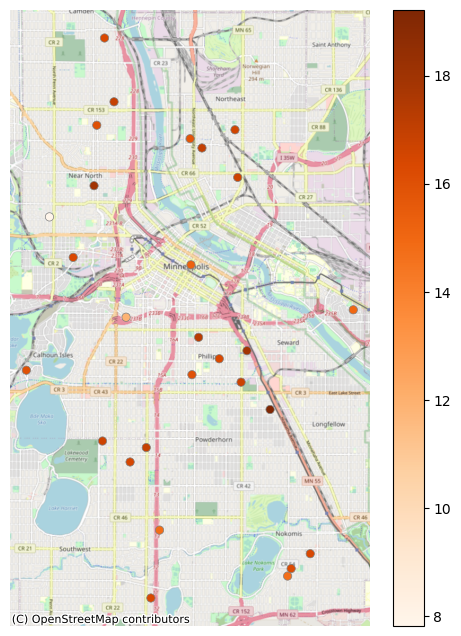

In [37]:
# Full Day Mean

f, ax = plt.subplots(1, figsize = (6,8))

avgs_gdf.plot('pm25_fullDay_mean',
             legend = True,
              cmap = 'Oranges',
              # scheme='Quantiles',
              # k=4,
              edgecolor = 'Grey',
              linewidth = .5,
             ax = ax)

ctx.add_basemap(ax=ax,
                crs = avgs_gdf.crs,
               source = ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()

/tmp/ipykernel_10509/3715049521.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


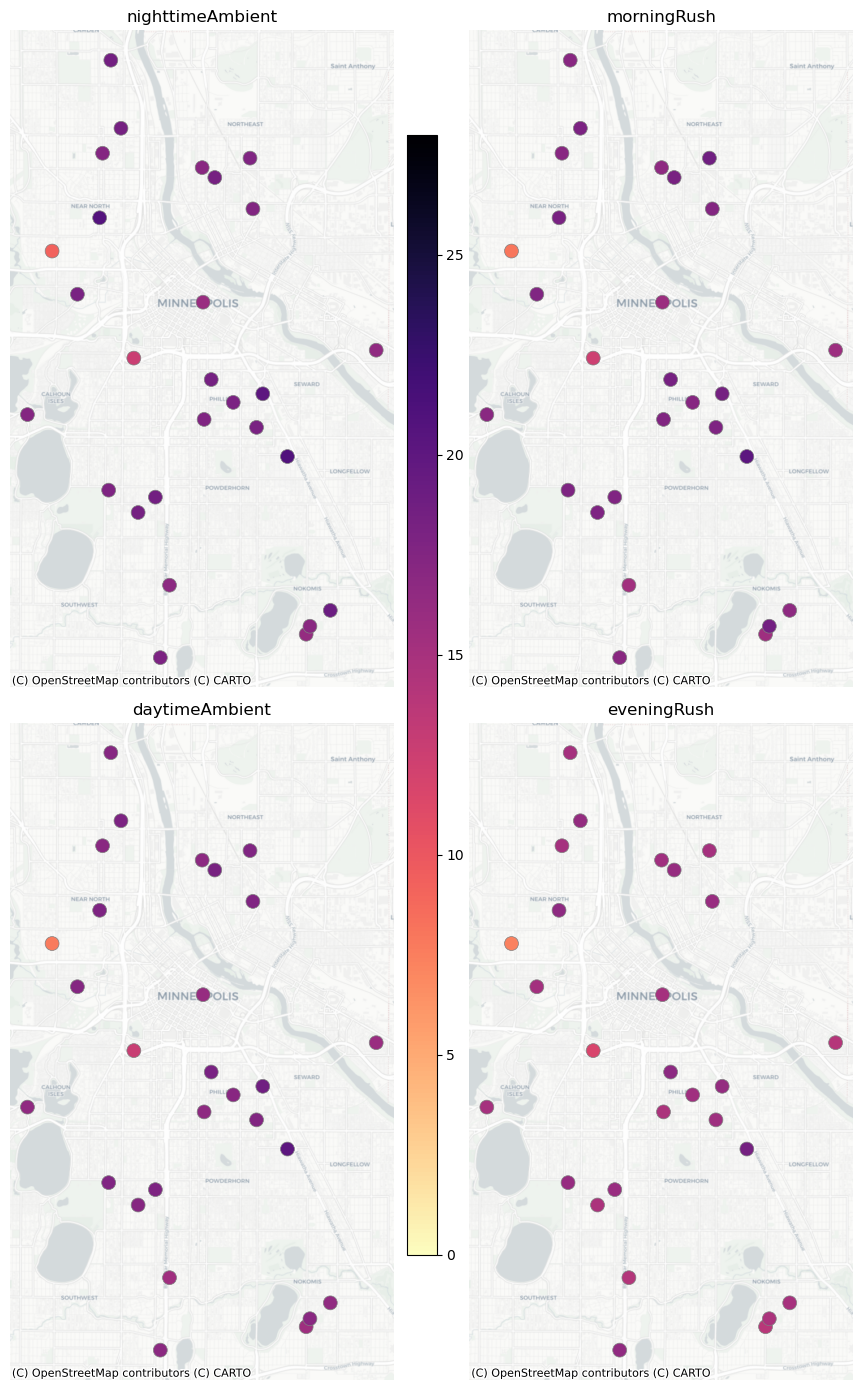

In [41]:
# By Times

import matplotlib.cm as cm
import matplotlib.colors as mcolors


times = ['nighttimeAmbient', 'morningRush',
         'daytimeAmbient', 'eveningRush']

f, axs = plt.subplots(2,2, figsize = (10,14))

value_min = 0
value_max = 28
cmap = 'magma_r'

for i, ax in enumerate(axs.flatten()):
    
    ax.set_title(times[i])
    
    stat_name = 'pm25_' + times[i] + '_mean'

    avgs_gdf.plot(stat_name,
                  cmap = cmap,
                  vmin = value_min,
                  vmax = value_max,
                  # scheme='Quantiles',
                  # k=4,
                  edgecolor = 'Grey',
                  linewidth = .5,
                  markersize = 100,
                 ax = ax)

    ctx.add_basemap(ax=ax,
                    crs = avgs_gdf.crs,
                   source = ctx.providers.CartoDB.Positron)

    ax.set_axis_off()
    
    
# define a mappable based on which the colorbar will be drawn
mappable = cm.ScalarMappable(
    norm=mcolors.Normalize(value_min, value_max),
    cmap=cmap
)

# define position and extent of colorbar
cb_ax = f.add_axes([0.475, 0.1, .03, .8])

# draw colorbar
cbar = f.colorbar(mappable, cax=cb_ax, orientation='vertical')

plt.tight_layout()

plt.savefig('test.png')
plt.show()

In [ ]:
# Next we should look at seasons maybe.